# Estimation of MET cross section with Madgraph 3.6.0

In [ ]:
# !pip install numpy pandas sympy matplotlib 
# !wget https://launchpad.net/mg5amcnlo/3.0/3.6.x/+download/MG5_beta_v3.6.2.tgz
# !sudo apt-get update

In [ ]:
# mg5: import model DMsimp_s_spin0

In [1]:
import pandas as pd

# Criação da tabela de referência de partículas
particle_data = {
    "PID": [11, -11, 13, -13, 22, 12, -12, 14, -14, 16, -16, 1, -1, 2, -2, 3, -3, 4, -4, 5, -5, 21, 23, 24, -24],
    "Name": [
        "Electron", "Positron", "Muon", "Anti-Muon", "Photon",
        "Electron Neutrino", "Electron Anti-Neutrino", "Muon Neutrino", "Muon Anti-Neutrino",
        "Tau Neutrino", "Tau Anti-Neutrino", "Down Quark", "Anti-Down Quark",
        "Up Quark", "Anti-Up Quark", "Strange Quark", "Anti-Strange Quark",
        "Charm Quark", "Anti-Charm Quark", "Bottom Quark", "Anti-Bottom Quark",
        "Gluon", "Z Boson", "W+ Boson", "W- Boson"
    ],
    "Symbol": [
        "e-", "e+", "mu-", "mu+", "a",
        "ve", "ve~", "vm", "vm~",
        "vt", "vt~", "d", "d~",
        "u", "u~", "s", "s~",
        "c", "c~", "b", "b~",
        "g", "z", "w+", "w-"
    ]
}

# Criação do DataFrame com as informações de partículas
particle_df = pd.DataFrame(particle_data)
particle_df.to_csv('particle_names.csv', index=False)
print(particle_df)


    PID                    Name Symbol
0    11                Electron     e-
1   -11                Positron     e+
2    13                    Muon    mu-
3   -13               Anti-Muon    mu+
4    22                  Photon      a
5    12       Electron Neutrino     ve
6   -12  Electron Anti-Neutrino    ve~
7    14           Muon Neutrino     vm
8   -14      Muon Anti-Neutrino    vm~
9    16            Tau Neutrino     vt
10  -16       Tau Anti-Neutrino    vt~
11    1              Down Quark      d
12   -1         Anti-Down Quark     d~
13    2                Up Quark      u
14   -2           Anti-Up Quark     u~
15    3           Strange Quark      s
16   -3      Anti-Strange Quark     s~
17    4             Charm Quark      c
18   -4        Anti-Charm Quark     c~
19    5            Bottom Quark      b
20   -5       Anti-Bottom Quark     b~
21   21                   Gluon      g
22   23                 Z Boson      z
23   24                W+ Boson     w+
24  -24                W-

In [2]:
particle_df = pd.read_csv('particle_names.csv')


In [4]:
import subprocess
import os
import pandas as pd
import mplhep as hep
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

MG_VERSION = "v3_6_2"

def run_madgraph(madgraph_process: str, event_name: str, run_parameters: dict):
    # Definir o diretório onde o MadGraph está instalado e o diretório de trabalho
    particle_df = pd.read_csv('particle_names.csv')
    current_path = os.getcwd()

    madgraph_path = f"{current_path}/MG5_aMC_{MG_VERSION}/bin/mg5_aMC"
    working_dir = f"{current_path}/workdir"

    process_dir = os.path.join(working_dir, event_name)
    
    # Crie um arquivo de comando do MadGraph para geração de eventos
    def run_command_mg5(command: str):
        command_file = os.path.join(working_dir, "process_command.txt")
        
        with open(command_file, "w") as f:
            f.write(command)
            
        # Execute o MadGraph usando o subprocess
        try:
            subprocess.run([madgraph_path, command_file], cwd=working_dir, check=True);
            print("MadGraph executado com sucesso.")
        except subprocess.CalledProcessError as e:
            print("Erro ao executar MadGraph:", e)

    run_command_mg5(f""" generate {madgraph_process}
            output {event_name}""")

    # Path to param_card.dat
    param_card_path = os.path.join(process_dir, "Cards", "param_card.dat")

    # Function to edit parameters in param_card.dat
    def edit_param_card(param_card_path, parameters):
        with open(param_card_path, 'r') as file:
            lines = file.readlines()

        # Modify parameters as specified in 'parameters' dictionary
        with open(param_card_path, 'w') as file:
            for line in lines:
                for param, value in parameters.items():
                    # Replace the value for the given parameter name in the param_card file
                    if param in line:
                        # Preserve line formatting by replacing the value at the correct position
                        parts = line.split()
                        if len(parts) >= 2:
                            parts[-1] = str(value)  # Replace the last element with new value
                            line = " ".join(parts) + "\n"
                file.write(line)

    # Define parameters to modify: keys are param names, values are the new values
    # Adjust these parameter names based on your process and param_card format
    # parameters_to_modify = {
    #     "MASS 6": 172.5,     # Modify the top quark mass, for example
    #     "WIDTH 6": 1.32,     # Modify the top quark width
    # }
    # Edit the param_card.dat with specified parameters
    #edit_param_card(param_card_path, parameters_to_modify)
    #print("Parameters in param_card.dat have been updated.")

    # Path to run_card.dat
    run_card_path = os.path.join(process_dir, "Cards", "run_card.dat")

    # Function to edit parameters in run_card.dat
    def edit_run_card(run_card_path, run_parameters):
        with open(run_card_path, 'r') as file:
            lines = file.readlines()

        # Modify parameters as specified in 'parameters' dictionary
        with open(run_card_path, 'w') as file:
            for line in lines:
                for param, value in run_parameters.items():
                    # Replace the value for the given parameter name in the run_card file
                    if param in line:
                        parts = line.split("=")
                        if len(parts) >= 2:
                            parts[0] = f"     {value}      "
                            line = "=".join(parts)
                        print("new line modified: ", line)

                file.write(line)

    # Define parameters to modify: keys are parameter names in the run_card, values are the new values
    edit_run_card(run_card_path, run_parameters)

    ## Run MG after uptate parameters and run card 
    run_command_mg5(f"launch {process_dir}\n")



    # Caminho para o arquivo de saída com eventos gerados
    output_file = os.path.join(working_dir, f"{event_name}/Events/run_01/unweighted_events.lhe")
    try:
        output_zip_file = os.path.join(working_dir, f"{event_name}/Events/run_01/unweighted_events.lhe.gz")
        subprocess.run(["gzip", "-d", output_zip_file], cwd=working_dir)
        print("Arquivo LHE descompactado com sucesso.")
    except FileNotFoundError:
        print('Arquivo ja foi descompactado')

    # Função para extrair a seção transversal (cross-section) do arquivo LHE
    def get_cross_section(lhe_file):
        cross_section = None
        with open(lhe_file, 'r') as file:
            in_init_block = False
            for line in file:
                if "<init>" in line:
                    in_init_block = True
                elif "</init>" in line:
                    in_init_block = False
                    break
                elif in_init_block:
                    data = line.strip().split()
                    if len(data) <= 6:
                        cross_section = float(data[0]) 
                        error = float(data[1])
                        break
        return cross_section, error

    # Função para ler o arquivo LHE e converter para um DataFrame do Pandas, incluindo ID do evento
    def parse_lhe_file(file_path, cross_section, error):
        events = []
        event_id = 0

        with open(file_path, 'r') as file:
            in_event = False
            for line in file:
                if "<event>" in line:
                    in_event = True
                    event = []
                    event_id += 1  # Incrementa o ID do evento a cada novo evento
                elif "</event>" in line:
                    in_event = False
                    events.append(event)
                elif in_event:
                    data = line.strip().split()
                    if len(data) >= 6:
                        try:
                            particle_data = list(map(float, data))
                            particle_data.append(event_id)  # Adiciona o ID do evento à partícula
                            event.append(particle_data)
                        except ValueError:
                            print('error in line', data)
                            pass
                                        
        # Converte a lista de eventos para um DataFrame
        columns = ["PID", "status", "Mmother1", "mother2", "color1", "color2", "px", "py", "pz", "E", "M", "Lifetime", "Spin", "Event_ID"]
        df = pd.DataFrame([item for sublist in events for item in sublist], columns=columns)
        # Adiciona uma coluna de cross-section (mesmo valor para todos os eventos)
        df["cross_section"] = cross_section #pb
        df['cross_section_error'] = error #± pb
        return df

    # Extraia a cross-section do arquivo LHE
    cross_section_value, cross_section_error = get_cross_section(output_file)

    # Parse o arquivo LHE e crie o DataFrame com a seção transversal e ID do evento
    if cross_section_value:
        df_events = parse_lhe_file(output_file, cross_section_value, cross_section_error)
        df_events = df_events.dropna(subset='E').reset_index(drop=True)
        df_events = df_events.merge(particle_df, on='PID', how='left')
        #print(df_events.head())
        df_events.to_pickle(working_dir + '/' + event_name + '/df_events.pkl')
    else:
        print("Cross-section not found in the file.")

    return df_events


In [6]:
parameters_to_modify = {"ebeam1": 7000,
                        "ebeam2": 7000,
                        "nevents":10000,
                        #"dsqrt_shat" : 100, # minimal shat for full process,
                        #"pta":100, #       ! minimum pt for the photons 
                        #"ptamax": 1000,   #  ! maximum pt for the photons
                        #"mxx_min_pdg": "{12:2000}", # ! min invariant mass of a pair of particles X/X~ (e.g. {6:250})
                        #misset"  : 3000, #   ! minimum missing Et (sum of neutrino's momenta)
                        #"missetmax": 4000, #  ! maximum missing Et (sum of neutrino's momenta)
                          } # Beam 1 energy in GeV


df_events = run_madgraph('p p > h > t t~ Z', 'dmsimp', parameters_to_modify)

************************************************************
*                                                          *
*                     W E L C O M E to                     *
*              M A D G R A P H 5 _ a M C @ N L O           *
*                                                          *
*                                                          *
*                 *                       *                *
*                   *        * *        *                  *
*                     * * * * 5 * * * *                    *
*                   *        * *        *                  *
*                 *                       *                *
*                                                          *
*         VERSION 3.6.2                 2025-03-19         *
*                                                          *
*    The MadGraph5_aMC@NLO Development Team - Find us at   *
*              http://madgraph.phys.ucl.ac.be/             *
*                       

stty: 'standard input': Inappropriate ioctl for device


value '[]' for entry 'bypass_check' is not valid.  Preserving previous value: '[]'.
allowed values are any list composed of the following entries: partonshower
Generating 10000 events with run name run_01
survey  run_01 
INFO: compile directory 
Not able to open file /home/mjrxy/resonant-scalar-madg/madgraph/workdir/dmsimp/crossx.html since no program configured.Please set one in ./input/mg5_configuration.txt
compile Source Directory
Using random number seed offset = 21
INFO: Running Survey 
Creating Jobs
Working on SubProcesses
INFO: Compiling for process 1/1. 
INFO:     P1_qq_ttxz  


100%|██████████| 775/775 [00:00<00:00, 37658.26it/s]


INFO:     P1_qq_ttxz  
INFO:  Idle: 1,  Running: 0,  Completed: 0 [ current time: 16h23 ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  1.4s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 1 [  1.5s  ] 
INFO: End survey 
refine 10000
Creating Jobs
INFO: Refine results to 10000 
INFO: Generating 10000.0 unweighted events. 
sum of cpu time of last step: 0 second
INFO: Effective Luminosity 324701680.3311957 pb^-1 
INFO: need to improve 1 channels 
- Current estimate of cross-section: 3.6957e-05 +- 3.8899e-07
    P1_qq_ttxz 
INFO:  Idle: 1,  Running: 11,  Completed: 0 [ current time: 16h23 ] 
INFO:  Idle: 0,  Running: 11,  Completed: 1 [  3.5s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 12 [  4.3s  ] 
INFO: Combining runs 
sum of cpu time of last step: 10 seconds
INFO: finish refine 
refine 10000 --treshold=0.9
No need for second refine due to stability of cross-section
INFO: Combining Events 
combination of events done in 1.9901463985443115 s 
  === Results Summary for run: run_01 tag: tag

In [7]:
df_events

,PID,status,Mmother1,mother2,color1,color2,px,py,pz,E,M,Lifetime,Spin,Event_ID,cross_section,cross_section_error,Name,Symbol
0,-1.0,-1.0,0.0,0.0,0.0,501.0,-0.000000,0.000000,87.247353,87.247353,0.000,0.0,1.0,1.0,0.000037,7.205900e-08,Anti-Down Quark,d~
1,1.0,-1.0,0.0,0.0,501.0,0.0,0.000000,-0.000000,-1621.477901,1621.477901,0.000,0.0,-1.0,1.0,0.000037,7.205900e-08,Down Quark,d
2,6.0,1.0,1.0,2.0,502.0,0.0,130.817654,-7.537436,-842.538246,870.040096,173.000,0.0,-1.0,1.0,0.000037,7.205900e-08,NaN,NaN
3,-6.0,1.0,1.0,2.0,0.0,502.0,-14.035603,-157.828563,-467.996966,523.504550,173.000,0.0,-1.0,1.0,0.000037,7.205900e-08,NaN,NaN
4,23.0,1.0,1.0,2.0,0.0,0.0,-116.782051,165.365999,-223.695336,315.180608,91.188,0.0,0.0,1.0,0.000037,7.205900e-08,Z Boson,z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,2.0,-1.0,0.0,0.0,501.0,0.0,0.000000,0.000000,951.674492,951.674492,0.000,0.0,-1.0,10000.0,0.000037,7.205900e-08,Up Quark,u
49996,-2.0,-1.0,0.0,0.0,0.0,501.0,-0.000000,-0.000000,-183.712972,183.712972,0.000,0.0,1.0,10000.0,0.000037,7.205900e-08,Anti-Up Quark,u~
49997,6.0,1.0,1.0,2.0,502.0,0.0,225.680117,-126.286153,214.162374,377.722425,173.000,0.0,1.0,10000.0,0.000037,7.205900e-08,NaN,NaN
49998,-6.0,1.0,1.0,2.0,0.0,502.0,-106.738900,-113.982078,271.547084,357.843437,173.000,0.0,1.0,10000.0,0.000037,7.205900e-08,NaN,NaN


In [10]:
#df_events.to_csv('proton_z_met_1kk.csv')
df_events = pd.read_csv('proton_z_met_1kk.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'proton_z_met_1kk.csv'

In [8]:
total_cross_section = df_events.cross_section.iloc[0] * 1000
total_cross_section_error = df_events.cross_section_error.iloc[0]
print(total_cross_section, total_cross_section_error)

0.03743 7.2059e-08


In [9]:
df_events['neutrino'] = 1
df_events['neutrino'] = -1
df_events.loc[df_events['PID'].isin([12, 14, 16, ]), 'neutrino'] = True
df_events.loc[df_events['PID'].isin([-12, -14, -16]), 'anti_neutrino'] = True
#df_events.loc[df_events['neutrino'], 'PID'] = 12
#df_events['PID_abs'] = abs(df_events['PID'])
df_gp = df_events.groupby(['Event_ID', 'neutrino' ,'PID'], as_index=False)['E'].sum()


/tmp/ipykernel_2075789/1391731699.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'True' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_events.loc[df_events['PID'].isin([12, 14, 16, ]), 'neutrino'] = True


In [10]:
df_gp.loc[df_gp['E'] > 4000]

,Event_ID,neutrino,PID,E
442,89.0,-1,2.0,4476.895593
502,101.0,-1,2.0,4320.446445
977,196.0,-1,2.0,4320.486447
1722,345.0,-1,1.0,4628.578719
2117,424.0,-1,2.0,4231.411217
...,...,...,...,...
48797,9760.0,-1,2.0,5146.306442
48971,9795.0,-1,-2.0,4017.621691
49361,9873.0,-1,-2.0,4279.228539
49702,9941.0,-1,2.0,4088.446148


In [11]:
df_to_plot = df_gp.loc[df_gp['PID'].isin([12]), 'E'].to_numpy() * total_cross_section /1000000
df_to_plot

array([], dtype=float64)

In [19]:

# ZZ, a pair of heavier bosons.

def get_hist_bins(df_to_plot, bin_gev):
    
    gev_bin = abs(int((df_to_plot.max() - df_to_plot.min())  / bin_gev)) # Gev
    M_hist = np.histogram(df_to_plot, bins=gev_bin) #range=(rmin, rmax))
    # the tuple `M_hist` that this function gives is so common in python that it is recognized by mplhep plotting functions
    hist, bins = M_hist  # hist=frequency ; bins=Mass values
    return hist, bins
df_to_plot = df_gp.loc[df_gp['PID'].isin([12]), 'E'].to_numpy()
hist1, bins1 = get_hist_bins(df_to_plot, 10)
df_to_plot = df_gp.loc[df_gp['PID'].isin([12]), 'E'].to_numpy()

hist1, bins1 = get_hist_bins(df_to_plot, 10)
fig, ax = plt.subplots(figsize=(10, 5))
bin_gev = 5

hep.histplot(
    [hist1, hist1],
    bins=bins1,
    histtype="fill",
    stack=True,
    color=["b", "r"],
    alpha=0.5,
    edgecolor="black",
    label=rf"""$pp \to \gamma \nu_\ell \bar \nu_\ell$ 
    $\sigma = {total_cross_section}$ fb""",
    ax=ax,
)

ax.set_xlabel(r"$\nu_l \bar \nu_l$ (MET) energy (GeV)", fontsize=15)
ax.set_ylabel(f"Events / {bin_gev} GeV", fontsize=15)
#ax.set_xlim(rmin, rmax)
ax.legend()
fig.show()


ValueError: zero-size array to reduction operation maximum which has no identity

/tmp/ipykernel_135914/3366371981.py:29: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


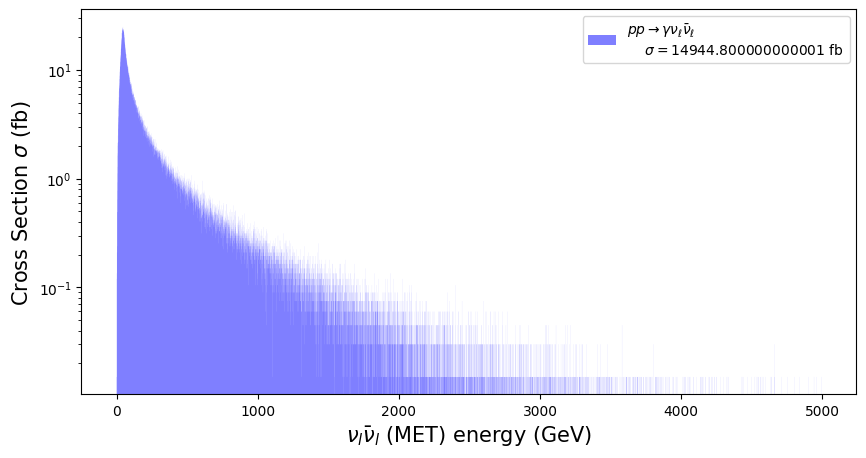

In [21]:

# ZZ, a pair of heavier bosons.
## converts to cross section
df_to_plot = df_gp.loc[df_gp['PID'].isin([12]), 'E'].to_numpy() 
bin_gev = 0.1
#gev_bin = abs(int((df_to_plot.max() - df_to_plot.min())  / bin_gev)) # Gev
M_hist = np.histogram(df_to_plot, bins=10000) #range=(rmin, rmax))
# the tuple `M_hist` that this function gives is so common in python that it is recognized by mplhep plotting functions


hist, bins = M_hist  # hist=frequency ; bins=Mass values
fig, ax = plt.subplots(figsize=(10, 5))
hist = hist * total_cross_section /1000000
hep.histplot(
    hist,
    bins=bins,
    histtype="fill",
    color="b",
    alpha=0.5,
    edgecolor="black",
    label=rf"""$pp \to \gamma \nu_\ell \bar \nu_\ell$ 
    $\sigma = {total_cross_section}$ fb""",
    ax=ax,
)

ax.set_xlabel(r"$\nu_l \bar \nu_l$ (MET) energy (GeV)", fontsize=15)
ax.set_ylabel(f"Cross Section $\sigma$ (fb) ", fontsize=15)
ax.set_yscale('log')
ax.legend()
fig.show()


In [22]:
hist_df = pd.DataFrame(M_hist).T.rename(columns={0: 'nevents', 1: 'energy_nu'})

In [23]:
hist_df['xsec'] = hist_df['nevents'] * total_cross_section /1000000

In [24]:
hist_df['integrated_xsec'] = 0
xsec_met = {}
for energy in range(1000, 6000, 100):
    xsec_met[energy] = hist_df.loc[hist_df['energy_nu'].between(energy, energy+100), 'xsec'].sum()


In [25]:
energy_xsec_df = pd.DataFrame.from_dict(xsec_met, orient='index', columns=['xsec_met']).reset_index().rename(columns={'index': 'energy_nu'}) 

In [26]:
energy_xsec_df.to_csv('energy_met_xsec.csv', index=False)

/tmp/ipykernel_135914/2663296924.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/tmp/ipykernel_135914/2663296924.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


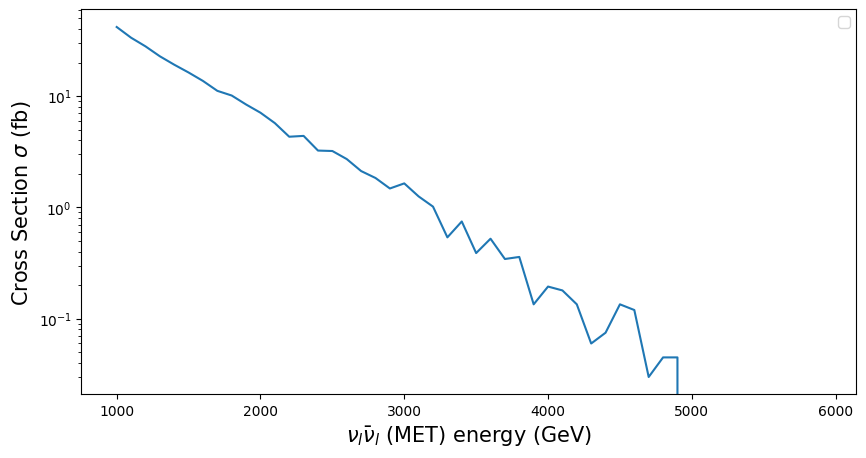

In [27]:
fig, ax = plt.subplots(figsize=(10, 5))
hist = hist * total_cross_section /1000000
ax.plot(energy_xsec_df['energy_nu'], energy_xsec_df['xsec_met'])
ax.set_xlabel(r"$\nu_l \bar \nu_l$ (MET) energy (GeV)", fontsize=15)
ax.set_ylabel(f"Cross Section $\sigma$ (fb) ", fontsize=15)
ax.set_yscale('log')
ax.legend()
fig.show()

/tmp/ipykernel_135914/3290483475.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


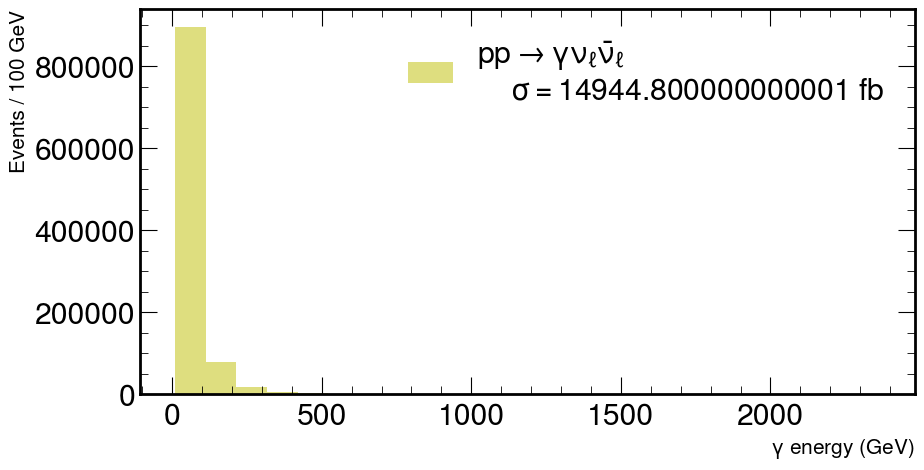

In [28]:
import mplhep as hep
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

hep.style.use("CMS")
# ZZ, a pair of heavier bosons.
df_to_plot = df_gp.loc[df_gp['PID'].isin([22]), 'E'].to_numpy()
df_to_plot
bin_gev = 100
gev_bin = abs(int((df_to_plot.max() - df_to_plot.min())  / bin_gev)) # Gev
M_hist = np.histogram(df_to_plot, bins=gev_bin) #range=(rmin, rmax))
# the tuple `M_hist` that this function gives is so common in python that it is recognized by mplhep plotting functions

hist, bins = M_hist  # hist=frequency ; bins=Mass values
fig, ax = plt.subplots(figsize=(10, 5))
hep.histplot(
    hist,
    bins=bins,
    histtype="fill",
    color="y",
    alpha=0.5,
    edgecolor="black",
    label=rf"""$pp \to \gamma \nu_\ell \bar \nu_\ell$ 
    $\sigma = {total_cross_section}$ fb""",
    ax=ax,
)

ax.set_xlabel(r"$\gamma$ energy (GeV)", fontsize=15)
ax.set_ylabel(f"Events / {bin_gev} GeV", fontsize=15)
#ax.set_xlim(rmin, rmax)
ax.legend()
fig.show()


<Axes: >

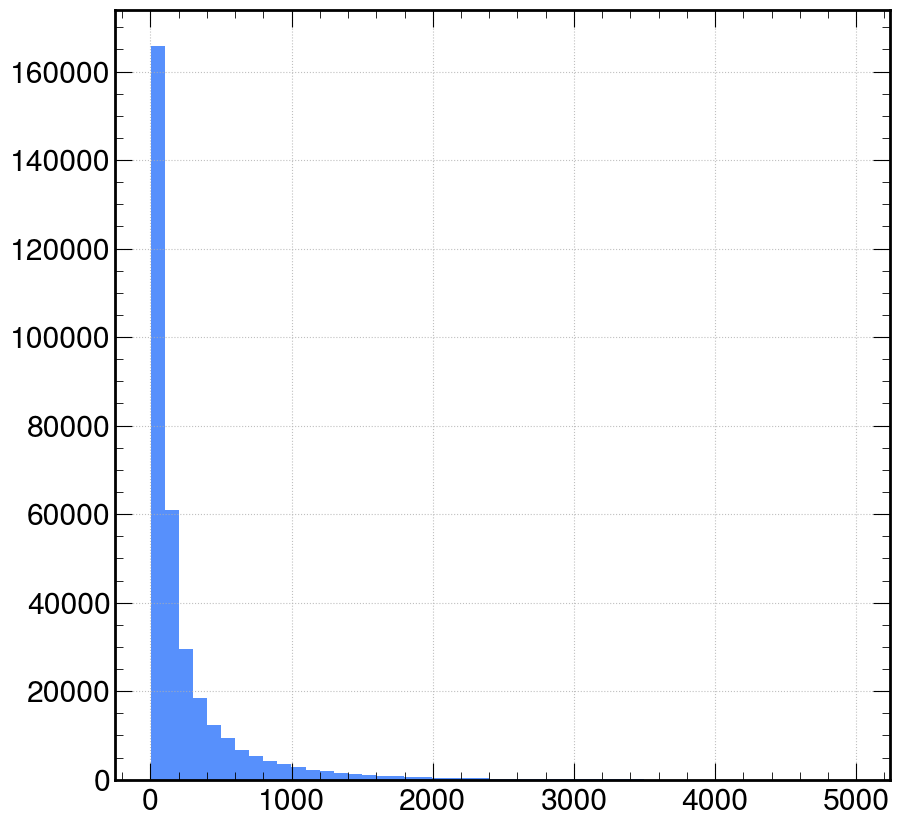

In [31]:
df_gp.loc[df_gp['PID'].isin([12]), 'E'].hist(bins=50)#.set_xlim(1000, 1500)


(1000.0, 1500.0)

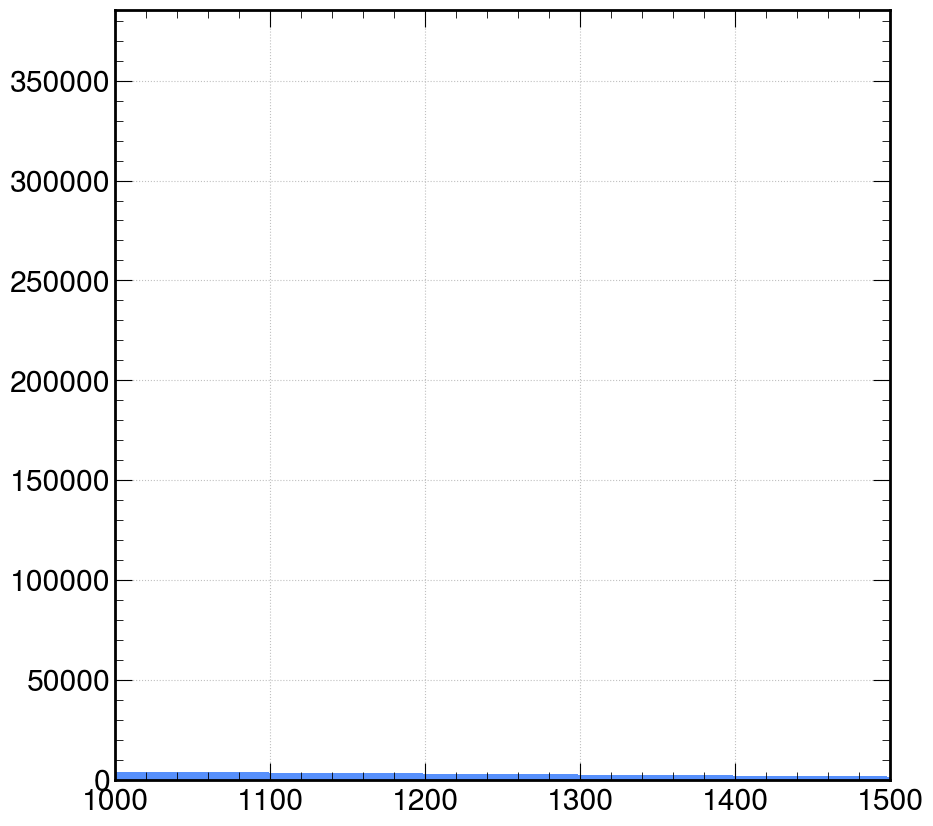

In [32]:
df_events.loc[df_events['PID'].isin([12, -12]), 'E'].hist(bins=50).set_xlim(1000, 1500)

In [33]:
df_events

,Unnamed: 0,PID,status,Mmother1,mother2,color1,color2,px,py,pz,...,M,Lifetime,Spin,Event_ID,cross_section,cross_section_error,Name,Symbol,neutrino,anti_neutrino
0,0,-1.0,-1.0,0.0,0.0,0.0,501.0,-0.000000,0.000000,26.295143,...,0.0,0.0,1.0,1.0,14.9448,0.005595,Anti-Down Quark,d~,-1,NaN
1,1,1.0,-1.0,0.0,0.0,501.0,0.0,0.000000,-0.000000,-90.457148,...,0.0,0.0,-1.0,1.0,14.9448,0.005595,Down Quark,d,-1,NaN
2,2,12.0,1.0,1.0,2.0,0.0,0.0,13.148818,6.728541,-65.894337,...,0.0,0.0,-1.0,1.0,14.9448,0.005595,Electron Neutrino,ve,True,NaN
3,3,-12.0,1.0,1.0,2.0,0.0,0.0,-20.712857,-17.372946,14.740016,...,0.0,0.0,1.0,1.0,14.9448,0.005595,Electron Anti-Neutrino,ve~,-1,True
4,4,22.0,1.0,1.0,2.0,0.0,0.0,7.564039,10.644405,-13.007682,...,0.0,0.0,-1.0,1.0,14.9448,0.005595,Photon,a,-1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4999995,4999995,-2.0,-1.0,0.0,0.0,0.0,501.0,-0.000000,0.000000,22.371330,...,0.0,0.0,-1.0,1000000.0,14.9448,0.005595,Anti-Up Quark,u~,-1,NaN
4999996,4999996,2.0,-1.0,0.0,0.0,501.0,0.0,0.000000,-0.000000,-152.764759,...,0.0,0.0,1.0,1000000.0,14.9448,0.005595,Up Quark,u,-1,NaN
4999997,4999997,14.0,1.0,1.0,2.0,0.0,0.0,-37.079267,-12.672226,-31.589324,...,0.0,0.0,-1.0,1000000.0,14.9448,0.005595,Muon Neutrino,vm,True,NaN
4999998,4999998,-14.0,1.0,1.0,2.0,0.0,0.0,36.702771,35.798366,-79.886091,...,0.0,0.0,1.0,1000000.0,14.9448,0.005595,Muon Anti-Neutrino,vm~,-1,True


array([[<Axes: title={'center': 'E'}>]], dtype=object)

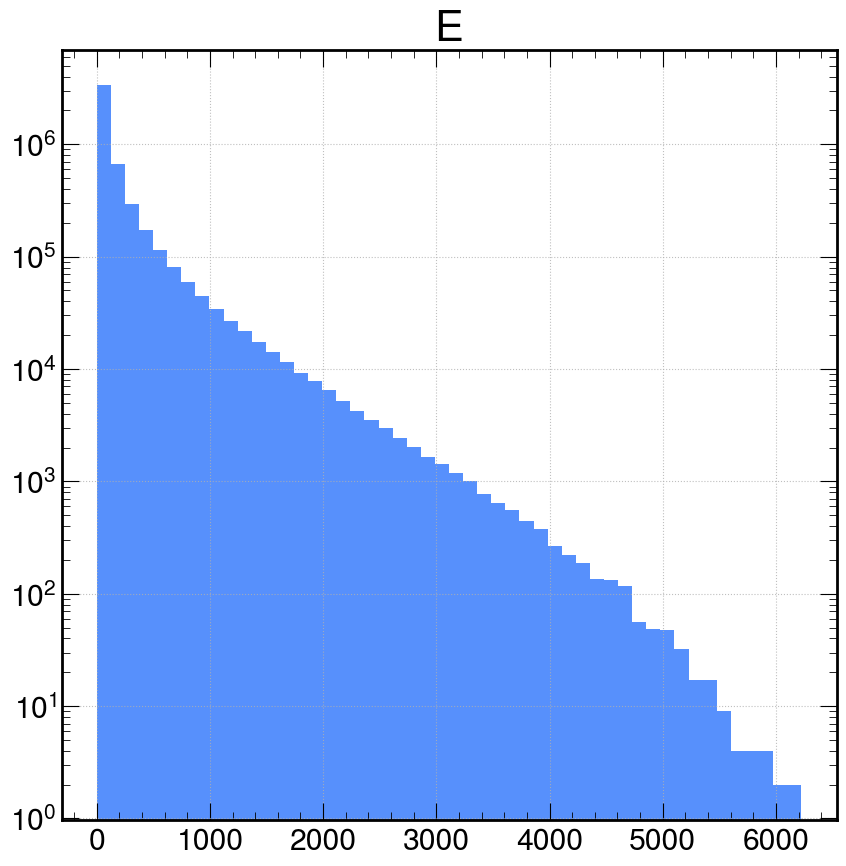

In [34]:
df_events.hist('E', bins=50, log=True)

In [35]:
df_events

,Unnamed: 0,PID,status,Mmother1,mother2,color1,color2,px,py,pz,...,M,Lifetime,Spin,Event_ID,cross_section,cross_section_error,Name,Symbol,neutrino,anti_neutrino
0,0,-1.0,-1.0,0.0,0.0,0.0,501.0,-0.000000,0.000000,26.295143,...,0.0,0.0,1.0,1.0,14.9448,0.005595,Anti-Down Quark,d~,-1,NaN
1,1,1.0,-1.0,0.0,0.0,501.0,0.0,0.000000,-0.000000,-90.457148,...,0.0,0.0,-1.0,1.0,14.9448,0.005595,Down Quark,d,-1,NaN
2,2,12.0,1.0,1.0,2.0,0.0,0.0,13.148818,6.728541,-65.894337,...,0.0,0.0,-1.0,1.0,14.9448,0.005595,Electron Neutrino,ve,True,NaN
3,3,-12.0,1.0,1.0,2.0,0.0,0.0,-20.712857,-17.372946,14.740016,...,0.0,0.0,1.0,1.0,14.9448,0.005595,Electron Anti-Neutrino,ve~,-1,True
4,4,22.0,1.0,1.0,2.0,0.0,0.0,7.564039,10.644405,-13.007682,...,0.0,0.0,-1.0,1.0,14.9448,0.005595,Photon,a,-1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4999995,4999995,-2.0,-1.0,0.0,0.0,0.0,501.0,-0.000000,0.000000,22.371330,...,0.0,0.0,-1.0,1000000.0,14.9448,0.005595,Anti-Up Quark,u~,-1,NaN
4999996,4999996,2.0,-1.0,0.0,0.0,501.0,0.0,0.000000,-0.000000,-152.764759,...,0.0,0.0,1.0,1000000.0,14.9448,0.005595,Up Quark,u,-1,NaN
4999997,4999997,14.0,1.0,1.0,2.0,0.0,0.0,-37.079267,-12.672226,-31.589324,...,0.0,0.0,-1.0,1000000.0,14.9448,0.005595,Muon Neutrino,vm,True,NaN
4999998,4999998,-14.0,1.0,1.0,2.0,0.0,0.0,36.702771,35.798366,-79.886091,...,0.0,0.0,1.0,1000000.0,14.9448,0.005595,Muon Anti-Neutrino,vm~,-1,True


In [36]:
df_events.merge(particle_df, on='PID', how='left')

,Unnamed: 0,PID,status,Mmother1,mother2,color1,color2,px,py,pz,...,Spin,Event_ID,cross_section,cross_section_error,Name_x,Symbol_x,neutrino,anti_neutrino,Name_y,Symbol_y
0,0,-1.0,-1.0,0.0,0.0,0.0,501.0,-0.000000,0.000000,26.295143,...,1.0,1.0,14.9448,0.005595,Anti-Down Quark,d~,-1,NaN,Anti-Down Quark,d~
1,1,1.0,-1.0,0.0,0.0,501.0,0.0,0.000000,-0.000000,-90.457148,...,-1.0,1.0,14.9448,0.005595,Down Quark,d,-1,NaN,Down Quark,d
2,2,12.0,1.0,1.0,2.0,0.0,0.0,13.148818,6.728541,-65.894337,...,-1.0,1.0,14.9448,0.005595,Electron Neutrino,ve,True,NaN,Electron Neutrino,ve
3,3,-12.0,1.0,1.0,2.0,0.0,0.0,-20.712857,-17.372946,14.740016,...,1.0,1.0,14.9448,0.005595,Electron Anti-Neutrino,ve~,-1,True,Electron Anti-Neutrino,ve~
4,4,22.0,1.0,1.0,2.0,0.0,0.0,7.564039,10.644405,-13.007682,...,-1.0,1.0,14.9448,0.005595,Photon,a,-1,NaN,Photon,a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4999995,4999995,-2.0,-1.0,0.0,0.0,0.0,501.0,-0.000000,0.000000,22.371330,...,-1.0,1000000.0,14.9448,0.005595,Anti-Up Quark,u~,-1,NaN,Anti-Up Quark,u~
4999996,4999996,2.0,-1.0,0.0,0.0,501.0,0.0,0.000000,-0.000000,-152.764759,...,1.0,1000000.0,14.9448,0.005595,Up Quark,u,-1,NaN,Up Quark,u
4999997,4999997,14.0,1.0,1.0,2.0,0.0,0.0,-37.079267,-12.672226,-31.589324,...,-1.0,1000000.0,14.9448,0.005595,Muon Neutrino,vm,True,NaN,Muon Neutrino,vm
4999998,4999998,-14.0,1.0,1.0,2.0,0.0,0.0,36.702771,35.798366,-79.886091,...,1.0,1000000.0,14.9448,0.005595,Muon Anti-Neutrino,vm~,-1,True,Muon Anti-Neutrino,vm~
